# Neural Network Thermometer $L=12$ - Ising 2D

Given a set of spin configurations, we would like to construct a probability distribution in order to find the most probable temperature value of this set. 

First, we load the necessary libraries, including [PyTorch](https://pytorch.org/), a suitable python library for deep learning models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
torch.manual_seed(12)

import sys
# sys.path.append('../modules')
from mc_ising2d import IsingMC
from net import Net

T_c = 2 / ( np.log(1 + np.sqrt(2)) )

In [2]:
L = 12

## Loading Ising data

The first step is to load the Ising data generated by Monte Carlo procedure. The file `L12_Ising2D_MC.pkl` was constructed considering a square lattice $L\times L$, with $L=12$, and generated 2000 spins configurations for each of 25 different temperatures $ T/J = 10^{-6}, 0.25, 0.5, ..., 5.5, 5.75, 6 $.

In [3]:
ising_data = pd.read_pickle(f'L{L}_Ising2D_MC.pkl')
ising_data.head()

,state,magn,energy,temp
0,"[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, ...",12,-24,6.0
1,"[0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, ...",-20,-52,6.0
2,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, ...",-2,-44,6.0
3,"[0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, ...",26,-60,6.0
4,"[1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...",6,-60,6.0


In the thermodynamic limit $( L^2 \rightarrow \infty )$, the isotropic Ising model in a square lattice was analytically solved by [Lars Onsager](https://en.wikipedia.org/wiki/Lars_Onsager) in [1944](https://journals.aps.org/pr/abstract/10.1103/PhysRev.65.117). In this limit, the model show spontaneous magnetization for $ T < T_c$, with $T_c$ given by 

$$ \frac{T_c}{J} = \frac{2}{\log\left(1 + \sqrt{ 2}\right)} \approx 2.269185  \;. $$

With the class `IsingMC` we can check some thermodynamics quantities.

Method fit will construct states to the following temperatures: 
[3.5        3.4        3.3        3.2        3.1        3.
 2.9        2.8        2.7        2.6        2.5        2.4
 2.3        2.27918531 2.26918531 2.25918531 2.2        2.1
 2.         1.9        1.8        1.7        1.6        1.5
 1.4        1.3        1.2        1.1        1.        ]


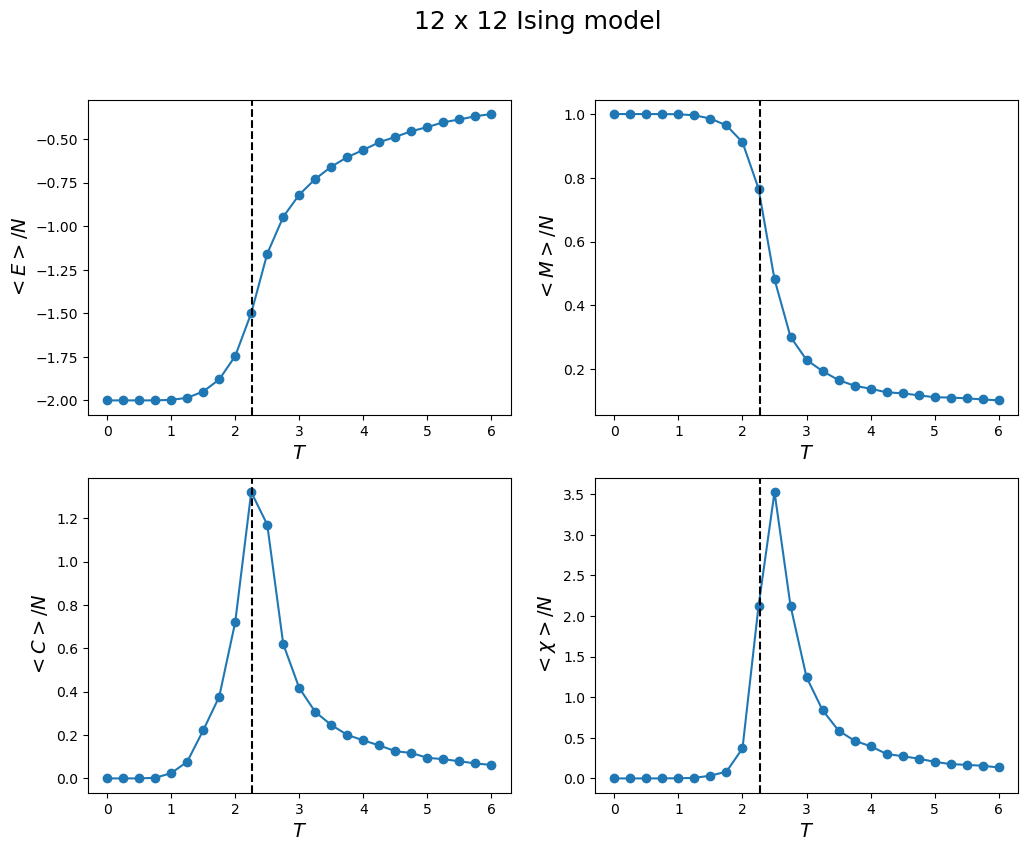

In [4]:
IsingMC(L= L).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)
# this shows specific heat (bottom left) and suseptibility (bottom right) per spin

Since our goal is to measure temperature, the target labels for the samples `ising_data['state']` of our supervised learning must be constructed with the information given by the columns `ising_data['temp']`. 

In [5]:
data = ising_data.drop(columns= ['energy', 'magn'])

## Constructing training and test sets

Using `train_test_split` from [`sklearn`](http://scikit-learn.org/) it is easy to split the data into training and test sets. Since `train_test_split` is a random process and our data has 1000 samples for each of the 29 temperatures values, we split the data for each temperature in order to avoid the possibility of a biased split towards some temperature value.

In [6]:
train_data_ = pd.DataFrame()

In [7]:
test_data_ = pd.DataFrame()


In [8]:
for _, temp in enumerate(data['temp'].value_counts().index.tolist()):
    
    train_data_T, test_data_T = train_test_split(data[data['temp'] == temp],
                                                 test_size= 0.2,
                                                 random_state= 12)
    
    train_data_ = pd.concat([train_data_, train_data_T])
    test_data_ = pd.concat([test_data_, test_data_T])

In [9]:
train_data_

,state,temp,temp_
1027,"[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",6.000000,6.000000
1538,"[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",6.000000,6.000000
1145,"[0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, ...",6.000000,6.000000
1922,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...",6.000000,6.000000
1631,"[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ...",6.000000,6.000000
...,...,...,...
49265,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000001,0.000001
49277,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000001,0.000001
49414,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000001,0.000001
49691,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000001,0.000001


In [10]:
test_data_

,state,temp,temp_
369,"[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...",6.000000,6.000000
1342,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...",6.000000,6.000000
520,"[1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, ...",6.000000,6.000000
1636,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, ...",6.000000,6.000000
1982,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",6.000000,6.000000
...,...,...,...
49738,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000001,0.000001
48769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000001,0.000001
49022,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000001,0.000001
48188,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000001,0.000001


## One-hot encoding

It is interesting to translate the targets into an [one-hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f) structure. 

In [11]:
train_data = pd.get_dummies(train_data_, columns=['temp'])
test_data = pd.get_dummies(test_data_, columns=['temp'])

In [12]:
train_data # lets remove title columns or not input title columns into the trianing

,state,temp_,temp_1e-06,temp_0.25,temp_0.5,temp_0.75,temp_1.0,temp_1.25,temp_1.5,temp_1.75,...,temp_3.75,temp_4.0,temp_4.25,temp_4.5,temp_4.75,temp_5.0,temp_5.25,temp_5.5,temp_5.75,temp_6.0
1027,"[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",6.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1538,"[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",6.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1145,"[0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, ...",6.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1922,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...",6.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1631,"[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ...",6.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49265,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000001,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49277,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000001,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49414,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000001,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49691,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000001,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
test_data

,state,temp_,temp_1e-06,temp_0.25,temp_0.5,temp_0.75,temp_1.0,temp_1.25,temp_1.5,temp_1.75,...,temp_3.75,temp_4.0,temp_4.25,temp_4.5,temp_4.75,temp_5.0,temp_5.25,temp_5.5,temp_5.75,temp_6.0
369,"[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...",6.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1342,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...",6.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
520,"[1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, ...",6.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1636,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, ...",6.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1982,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",6.000000,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49738,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000001,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
48769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000001,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49022,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000001,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
48188,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000001,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
# need to delete the 'temp_' column
train_data.drop('temp_', axis=1, inplace=True)
train_data

,state,temp_1e-06,temp_0.25,temp_0.5,temp_0.75,temp_1.0,temp_1.25,temp_1.5,temp_1.75,temp_2.0,...,temp_3.75,temp_4.0,temp_4.25,temp_4.5,temp_4.75,temp_5.0,temp_5.25,temp_5.5,temp_5.75,temp_6.0
1027,"[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1538,"[0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1145,"[0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1922,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1631,"[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49265,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49277,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49414,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49691,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [15]:
test_data.drop('temp_', axis=1, inplace=True)
test_data

,state,temp_1e-06,temp_0.25,temp_0.5,temp_0.75,temp_1.0,temp_1.25,temp_1.5,temp_1.75,temp_2.0,...,temp_3.75,temp_4.0,temp_4.25,temp_4.5,temp_4.75,temp_5.0,temp_5.25,temp_5.5,temp_5.75,temp_6.0
369,"[1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1342,"[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
520,"[1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1636,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1982,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49738,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
48769,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
49022,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
48188,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Creating a PyTorch dataset

Note that we use a [CUDA tensor type](https://pytorch.org/docs/stable/cuda.html), which implements GPU computation. If a GPU is not available, one should just withdraw the `cuda()` method.

In [16]:
X_train = torch.tensor(list(train_data['state']), dtype= torch.float)
y_train = torch.tensor(np.array(train_data[list(train_data.columns.values[1:])]), dtype= torch.float)

X_test = torch.tensor(list(test_data['state']), dtype= torch.float)
y_test = torch.tensor(np.array(test_data[list(test_data.columns.values[1:])]), dtype= torch.float)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([40000, 144])
torch.Size([40000, 25])
torch.Size([10000, 144])
torch.Size([10000, 25])


/var/folders/w5/2_pjjnd9621bd9yfl2mp6fd80000gn/T/ipykernel_41233/2415236983.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343685278/work/torch/csrc/utils/tensor_new.cpp:248.)
  X_train = torch.tensor(list(train_data['state']), dtype= torch.float)


In [17]:
batch_size = 100

train_loader = DataLoader(TensorDataset(X_train, y_train), 
                          batch_size= batch_size, 
                          shuffle= True)

## Training

The neural network is constructed in the class `Net`. Its code is available in the python script `net.py`.

We also have to define the network architecture, optimizer and loss function.

In [18]:
### Defining network architecture

input_size = X_train.shape[1]
out_size = y_train.shape[1]
layers_size = [input_size, 512, 256, 64]


### Initializing the class and defining the number of epochs

net = Net(layers_size, # this calls the Net class in the net.py script
          out_size)     

epochs = 215

print(net)


### Defining optimizer and loss training 

optimizer = optim.SGD(net.parameters(), 
                      lr= 0.1, 
                      weight_decay= 0.0)

loss_func = nn.BCELoss()


### Dictionary to record the results 

log_dic = {
    'epoch': [],
    'loss_train' : [],
    'loss_test' : [],
}


### Training 

for epoch in range(epochs):
    
    t0 = time.time()
    
    loss_epoch = []
    
    ### Loop over mini-batches
       
    for _, (input_data, target) in enumerate(train_loader):
        
        prediction= net(input_data)
        
        loss = loss_func(prediction, target)     
        
        loss_epoch.append(loss.item())
          
        optimizer.zero_grad()   # Clear gradients for the next mini-batches
        loss.backward()         # Backpropagation, compute gradients
        optimizer.step()
               
    ### Recording some results
    log_dic['epoch'].append(epoch)
    log_dic['loss_train'].append(np.mean(loss_epoch))
    test_error_ep = loss_func(net(X_test), y_test).item()
    log_dic['loss_test'].append(test_error_ep)
    t1 = time.time()
    
    ### Training status
    print('Epoch %d, Loss_train= %.10f, Loss_test= %.10f, Time= %.4f' % (epoch, 
                                                                         np.mean(loss_epoch), 
                                                                         test_error_ep, 
                                                                         t1-t0))

Net(
  (layers): ModuleList(
    (0): Linear(in_features=144, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=64, bias=True)
  )
  (out): Linear(in_features=64, out_features=25, bias=True)
)
Epoch 0, Loss_train= 0.1678735063, Loss_test= 0.1677124947, Time= 0.5939
Epoch 1, Loss_train= 0.1675112235, Loss_test= 0.1673420072, Time= 0.4765
Epoch 2, Loss_train= 0.1670429436, Loss_test= 0.1667948663, Time= 0.4770
Epoch 3, Loss_train= 0.1663556911, Loss_test= 0.1659738868, Time= 0.4683
Epoch 4, Loss_train= 0.1653219317, Loss_test= 0.1647105515, Time= 0.4845
Epoch 5, Loss_train= 0.1636947068, Loss_test= 0.1626651138, Time= 0.4747
Epoch 6, Loss_train= 0.1610844301, Loss_test= 0.1594431847, Time= 0.4706
Epoch 7, Loss_train= 0.1572155531, Loss_test= 0.1550261378, Time= 0.4763
Epoch 8, Loss_train= 0.1525662222, Loss_test= 0.1504556835, Time= 0.4828
Epoch 9, Loss_train= 0.1484901828, Loss_test= 0.1470842957, Tim

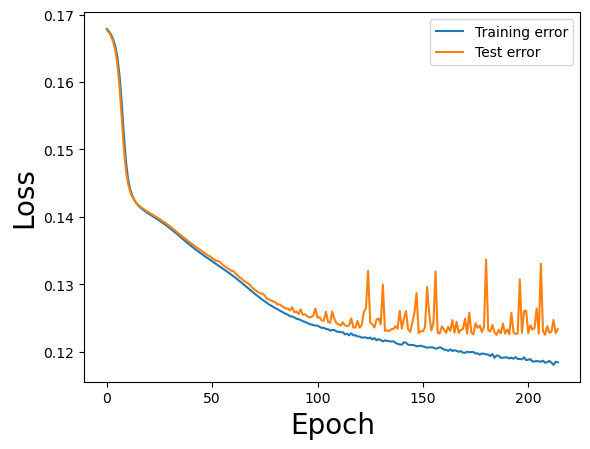

In [19]:
plt.plot(log_dic['epoch'], log_dic['loss_train'], label= 'Training error')
plt.plot(log_dic['epoch'], log_dic['loss_test'], label= 'Test error')
plt.xlabel('Epoch', fontsize= 20)
plt.ylabel('Loss', fontsize= 20)
plt.legend()
plt.show()

### Saving the trained model to a file

In [20]:
torch.save(net, f'L{L}_NN_Ising2D_MC.pt')

## Measuring temperatures with the trained neural network

As a sanity check, we use the trained neural network to construct the empirical probability temperature distribution for each set of labeled configurations in the test dataset. If the thermometer works fine, the empirical probabilities should be centered around the reference values.

To clean the presentation, we define a suitable plot function.

In [21]:
def thermometer(data,
                T_list,
                errorbar= True,
                x_min= 0, 
                x_max= 6.0,
                calib= False,
                NN_path= f'L{L}_NN_Ising2D_MC.pt'):
    
    net = Net() # this line is redundant
    net = torch.load(NN_path) 
    
    calib_curve = []
    temp_ = []
    
    for _, temp in enumerate(T_list):
        
           
        ising_state_temp = data[data['temp'] == temp]['state']
    
        X_ising_test = torch.tensor(list(ising_state_temp), dtype= torch.float)
    
        prediction= net(X_ising_test)
    
        x_ = np.sort(data['temp'].value_counts().index)
        
        # Calibration curve
        values, indices = torch.max(prediction, 1)
        calib_curve.append(x_[indices])
        temp_.append(temp)
        
        # Add the checks here, before the error occurs
        print(f"Length of x_: {len(x_)}")
        print(f"Shape of prediction: {prediction.shape}")
        print(f"Length of prediction mean: {len(prediction.cpu().mean(dim=0).data.numpy())}")
        
        
        if errorbar:
                               
            plt.errorbar(x_,
                         prediction.cpu().mean(dim=0).data.numpy(),
                         yerr= prediction.cpu().std(dim=0).data.numpy(),
                         marker= '.',
                         markersize= 10,
                         linewidth= 0.8,
                         capsize= 5.0,
                         elinewidth= 0.5,
                         markeredgewidth= 0.5,
                         label= 'T = %.6f' % temp )
            
        else:
            
            
             plt.plot(x_,
                      prediction.cpu().mean(dim=0).data.numpy(),
                      marker= '.',
                      markersize= 10,
                      linewidth= 0.8,
                      label= 'T = %.6f' % temp )
            
    
        plt.axvline(x= temp, linestyle= ':', linewidth= 0.5, color= 'gray')
    
        plt.xlabel('Temperature scale ', fontsize= 15)
        plt.ylabel('Softmax probability', fontsize= 15)
        

    plt.legend(loc= 'center left', bbox_to_anchor=(1, 0.5), fontsize= 'small')
    plt.ylim(0.0, plt.ylim()[1])
    plt.xlim([x_min, x_max])
    plt.show()
    
    if calib:
        return temp_, calib_curve

Defining a list encompassing the temperature scale, we can use the function `thermometer` to plot the empirical probability temperatures.

In [22]:
T_list = test_data_['temp'].value_counts().index.tolist()
T_list.sort()

The dashed lines are the labeled temperature values.

Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of 

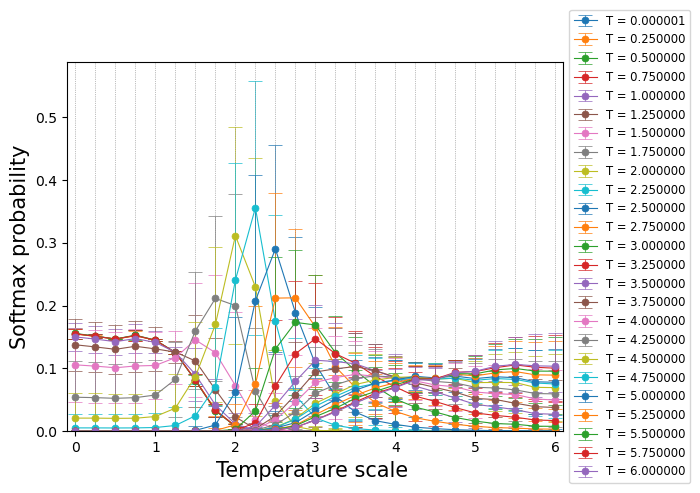

In [23]:
temp_, calib_curve = thermometer(test_data_, 
                                 T_list,
                                 calib= True,
                                 x_min= min(T_list) - 0.1, 
                                 x_max= max(T_list) + 0.1)

We can plot a kind of calibration curve. For convenience, we define the function `calibration_curve`.

In [24]:
def calibration_curve(temp_,
                      calib_curve,
                      L= L,
                      x_min= 0,
                      x_max= 6,
                      publication= False,
                      save= False, 
                      show= True,
                      grid= True,
                      red_critical= False,
                      Tc_vertical= True,
                      Tc_horizontal= True,
                      scale_step= 1,
                      critical_vl = 2.25):
    
    if red_critical:
        
        temp_c = []
        calib_curve_c = []
        
        temp__ = temp_.copy()
        calib_curve_ = calib_curve.copy()
        
        
        index_critical = np.argwhere(np.array(temp_) == critical_vl)
        index = index_critical[0][0]
        
        temp_c.append(temp_[index])
        calib_curve_c.append(calib_curve[index])
        
        temp__.pop(index)
        calib_curve_.pop(index)
        
      
    if publication:
        plt.figure(figsize=(3.375, 0.678*3.375))
        plt.xticks(fontsize= 6)
        plt.yticks(fontsize= 6)
        markersize = 4.0
        linewidth= 0.4
        fontsize_l = 7.0
        fontsize_t = 8.0
        fontsize_lg= 5.0
        capsize= 2.0   
        elinewidth= 0.2
        markeredgewidth = 0.2
        linewidth_v= 0.4
        linewidth_grid= 0.4
        
    else:
        markersize = 10.0
        linewidth= 0.8
        fontsize_l = 12.0
        fontsize_t = 12.0
        fontsize_lg= 10.0
        capsize= 5.0
        elinewidth= 0.5
        markeredgewidth = 0.5
        linewidth_v= 0.8
        linewidth_grid= 0.6
        
    
    if red_critical:
        
        plt.errorbar(temp__, 
                     np.mean(calib_curve_, axis=1),
                     yerr= np.std(calib_curve_, axis=1),
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
        
        plt.errorbar(temp_c, 
                     np.mean(calib_curve_c, axis=1),
                     yerr= np.std(calib_curve_c, axis=1),
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth,
                     color= 'C3')
        
        color_yx= 'C2'

        
    else:
        
               
        plt.errorbar(temp_, 
                     np.mean(calib_curve, axis=1),
                     yerr= np.std(calib_curve, axis=1),
                     marker= '.',
                     markersize= markersize,
                     linewidth= linewidth,
                     capsize= capsize,
                     elinewidth= elinewidth,
                     markeredgewidth= markeredgewidth)
            
        color_yx= 'C1'
        
            
    plt.xlabel('$T_{mc}$', fontsize= fontsize_l)
    plt.ylabel('$T_{nn}$', fontsize= fontsize_l)
    
    if Tc_vertical:
        
        if red_critical:
            color_Tc= 'C3'
        else:
            color_Tc= 'black'
            
        plt.axvline(x= T_c, linestyle= ':', linewidth= linewidth_v, color= color_Tc)
    
    
    if Tc_horizontal:
        
        if red_critical:
            color_Tc= 'C3'
        else:
            color_Tc= 'black'
            
        plt.axhline(y= T_c, linestyle= ':', linewidth= linewidth_v, color= color_Tc)
            
      
    start= plt.xlim()[0]
    end= plt.xlim()[1]
      
    plt.ylim(start, end)
    plt.xlim(start, end)
    
    
    plt.xticks(np.arange(x_min, x_max+ scale_step, scale_step))
    plt.yticks(np.arange(x_min, x_max+ scale_step, scale_step))
    
    plt.grid(visible=grid,linewidth= linewidth_grid,linestyle= ':')
    
    if save:
        if publication:
            path_fig = 'PUB_CALIB_THERM_L%d_Onsager.pdf' % L
            plt.savefig(path_fig , bbox_inches='tight')
        else:
            path_fig = 'CALIB_THERM_L%d_Onsager.pdf' % L
            plt.savefig(path_fig, bbox_inches='tight')
            
    if show:
        plt.show()

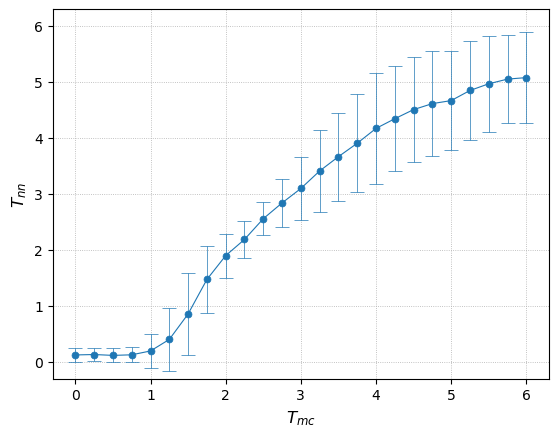

In [25]:
calibration_curve(temp_,
                  calib_curve,
                  L= L,
                  x_min= 0,
                  x_max= 6,
                  publication= False,
                  save= False,
                  red_critical= False,
                  Tc_vertical= False,
                  Tc_horizontal= False,
                  scale_step= 1,
                  critical_vl = 2.25)

The fact that the thermometer would indicate a flow towards critical temperature if the measure is in the interval $2.25 \pm 0.36$ is crucial to our argument that a wide range of magnetization values of the RBM fixed point would be identified by the thermometer as a flow towards $T_c$.

Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25


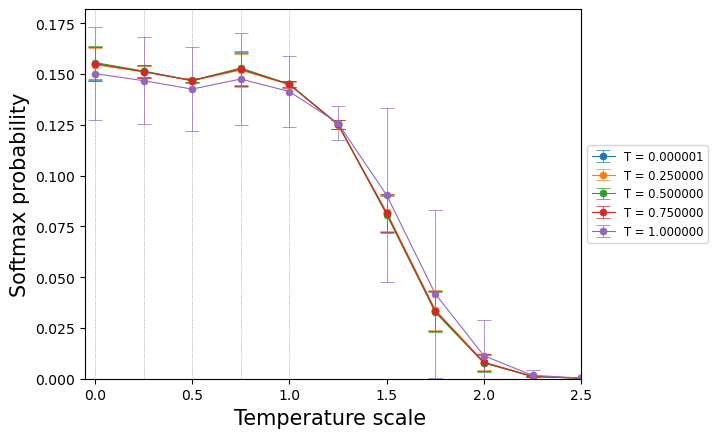

In [26]:
thermometer(test_data_, 
            T_list[:5],
            x_min= min(T_list[:5]) - 0.05, x_max= 2.5)

Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25


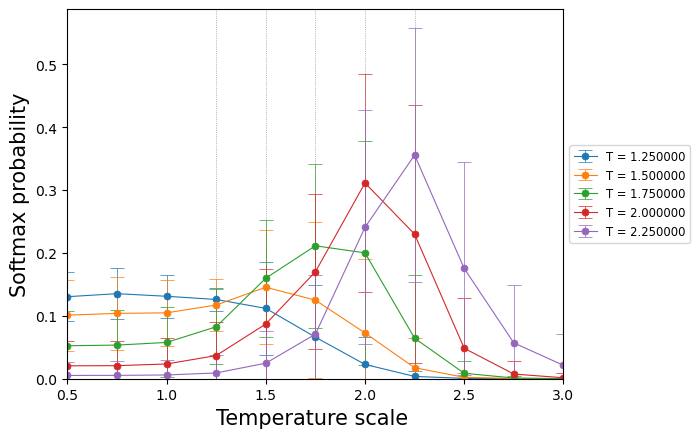

In [27]:
thermometer(test_data_, 
            T_list[5:10],
            x_min= 0.5, x_max= 3.0)

Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25


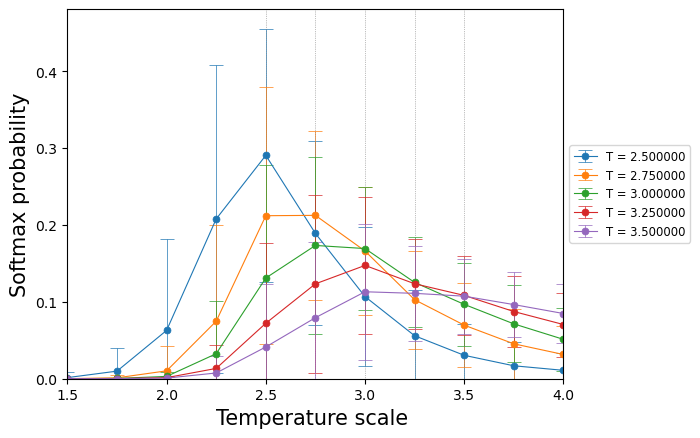

In [28]:
thermometer(test_data_, 
            T_list[10:15],
            x_min= 1.5, x_max= 4)

Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25


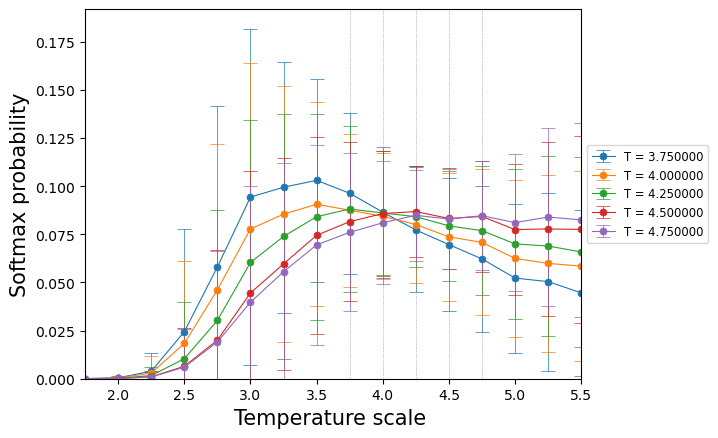

In [29]:
thermometer(test_data_, 
            T_list[15:20],
            x_min= 1.75, x_max= 5.5)

Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25
Length of x_: 25
Shape of prediction: torch.Size([400, 25])
Length of prediction mean: 25


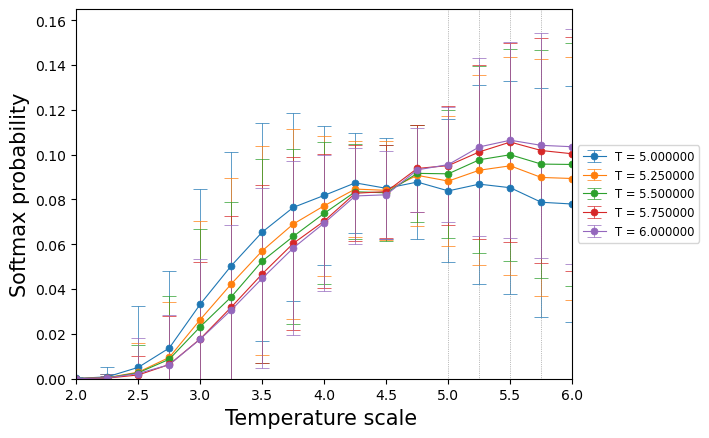

In [30]:
thermometer(test_data_, 
            T_list[20:25],
            x_min= 2.0, x_max= 6.0)

## Error in the temperature measure near $T_c$ in the magnetization point of view

In this section we analyze the standard deviation of the thermometer measure near $T_c$ from the magnetization point of view. That is, how the magnetization, which can be measured directly from the visible layers of the RBM, varies within the uncertainty interval defined by thermometer. 

We calculate the standard deviation near critical temperature.

In [31]:
index_critical = np.argwhere(np.array(temp_) == 2.25)
index = index_critical[0][0]

In [32]:
temp_c = temp_[index]
std__c = np.std(calib_curve, axis=1)[index]

print(temp_c)
print(std__c)

2.25
0.3227905158341977


The fact that the thermometer would indicate a flow towards critical temperature if the measure is in the interval $2.25 \pm 0.36$ is crucial to our argument that a wide range of magnetization values of the RBM fixed point would be identified by the thermometer as a flow towards $T_c$.

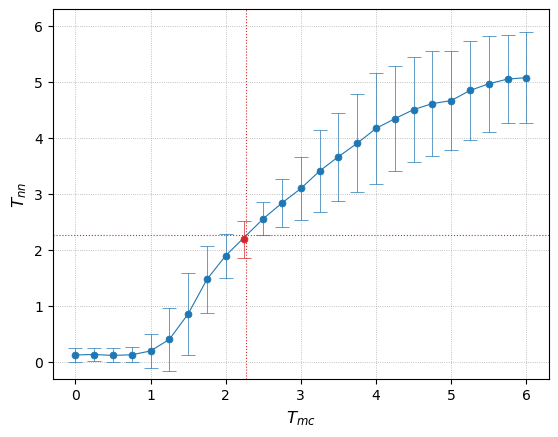

In [33]:
calibration_curve(temp_,
                  calib_curve,
                  L= L,
                  x_min= 0,
                  x_max= 6,
                  publication= False,
                  save= False,
                  red_critical= True,
                  grid= True,
                  Tc_vertical= True,
                  Tc_horizontal= True,
                  scale_step= 1,
                  critical_vl = temp_c)

The functions below are conveniently constructed for the purpose of plotting the magnetization with a colored area related to the standard deviation of the thermometer near $T_c$.

In [34]:
def mag_computation(L,
                    spin_MC,
                    Tc_scaled= False):
    
    T_c = 2 / ( np.log(1 + np.sqrt(2)) )
    N_spins = L*L
    
    if Tc_scaled:
        spin_MC['temp_'] = spin_MC['temp'] / T_c
        
    else:
        spin_MC['temp_'] = spin_MC['temp'] 
               
    expec_val_per_spin_MAGN = abs(spin_MC['magn']).groupby(spin_MC['temp_']).mean() / N_spins
    
    return expec_val_per_spin_MAGN



def mag_plot_std(L, 
                 spin_MC,
                 temp_c, 
                 std__c,
                 num_std= 1,
                 y_horiz= 0.65068,
                 y_dashed= False,
                 Tc_scaled= False, 
                 save= False, 
                 publication= False,
                 show= True,
                 inset= False):
    
    T_c = 2 / ( np.log(1 + np.sqrt(2)) )
    
    if publication:
        if inset:
            #plt.xticks(fontsize= 16)
            #plt.yticks(fontsize= 16)
            markersize = 0.45
            linewidth= 0.2
            fontsize_l = 7.0
            fontsize_t = 3.0
            fontsize_lg= 3.0
            linewidth_v = 0.15
            color = 'C0'
            color_e = 'C3'
            path_fig = 'PUB_MAG_MC_near_Tc_L%d_std%d_inset.pdf' % (L, num_std)

        else:
            plt.figure(figsize=(3.375, 0.678*3.375))
            plt.xticks(fontsize= 6)
            plt.yticks(fontsize= 6)
            markersize = 1.5
            linewidth= 0.4
            fontsize_l = 7.0
            fontsize_t = 8.0
            fontsize_lg= 5.0
            linewidth_v = 0.5
            color = 'C0'
            color_e = 'C3'
            path_fig = 'PUB_MAG_MC_near_Tc_L%d_std%d.pdf' % (L, num_std)
            
    
    else:
        if inset:
            path_fig = 'MAG_MC_near_Tc_L%d_std%d_inset.pdf' %  (L, num_std)
            markersize= 1.5
            linewidth= 0.4
            fontsize_l= 6.0
            fontsize_t= 5.0
            fontsize_lg= 5.0
            linewidth_v = 0.5
            color = 'C0'
            color_e = 'C3'
        else:
            path_fig = 'MAG_MC_near_Tc_L%d_std%d.pdf' %  (L, num_std)
            markersize= 5.0
            linewidth= 0.8
            fontsize_l= 12.0
            fontsize_t= 12.0
            fontsize_lg= 10.0
            linewidth_v = 1.0
            color = 'C0'
            color_e = 'C3'
        
    magn = mag_computation(L= L, 
                           spin_MC= spin_MC,
                           Tc_scaled= Tc_scaled)
        
    plt.plot(magn, 
             '-o',
             label= 'L = %d' % L,
             color= color, 
             markersize= markersize,
             linewidth= linewidth)
    
    if Tc_scaled:
        z1 = (temp_c + num_std*std__c)/temp_c
        z2 = (temp_c - num_std*std__c)/temp_c
        dashed_v = 1.0
    else:
        z1 = temp_c + num_std*std__c
        z2 = temp_c - num_std*std__c
        dashed_v = T_c
    
    plt.axvline(x= dashed_v, linestyle= ':', linewidth= linewidth_v, color= color_e)
    
    plt.axvline(x= z1, linestyle= ':', linewidth= linewidth_v, color= color_e)
    plt.axvline(x= z2, linestyle= ':', linewidth= linewidth_v, color= color_e)
    
    if y_dashed:
        plt.axhline(y= y_horiz, linestyle= ':', linewidth= linewidth_v, color= 'black')
      
    plt.axvspan(z1, z2, alpha=0.075, color= color_e)
    
    plt.tick_params(axis='both', labelsize= fontsize_t)
    
    
    if not inset:
        plt.ylabel('$<M>/N$', fontsize= fontsize_l)
        plt.legend(fontsize= fontsize_lg)
        if Tc_scaled:
            plt.xlabel('$T / T_c$', fontsize= fontsize_l)
        else:
            plt.xlabel('$T$', fontsize= fontsize_l)
            
    else:
        plt.legend(fontsize= fontsize_lg)
            
    if save:
        plt.savefig(path_fig , bbox_inches='tight')
        
    if show:
        plt.show()

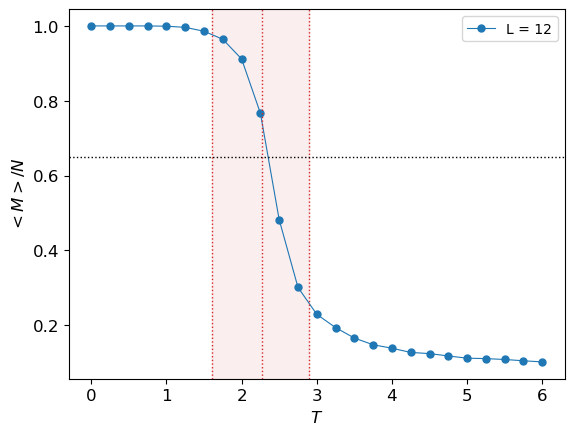

In [35]:
mag_plot_std(L= L, 
             spin_MC= ising_data, 
             Tc_scaled= False, 
             temp_c= temp_c, 
             std__c= std__c,
             num_std= 2,
             y_horiz= 0.65068,
             y_dashed= True,
             save= False, 
             publication= False)

### Magnetization plot as an inset in calibration curve plot

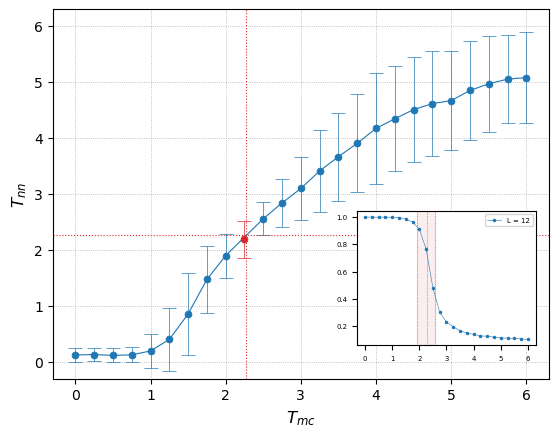

In [36]:
publication= False
save= False
L = 12


if publication:
    plt.figure(figsize= (3.375, 0.678*3.375))
    if save:
        path_file = 'PUB_CALIB_THERM_L%d_Onsager_INSET.pdf' % L
        
else:
    if save:
        path_file = 'CALIB_THERM_L%d_Onsager_INSET.pdf' % L
        
        


calibration_curve(temp_,
                  calib_curve,
                  L= L,
                  x_min= 0,
                  x_max= 6,
                  publication= False,
                  save= False,
                  show= False,
                  red_critical= True,
                  critical_vl = temp_c)

a = plt.axes([0.6, 0.18, 0.28, 0.28])


mag_plot_std(L= L, 
             spin_MC= ising_data, 
             Tc_scaled= False, 
             temp_c= temp_c, 
             std__c= std__c,
             save= False, 
             publication= False,
             show= False, 
             inset= True)

if save:
    plt.savefig(path_file, bbox_inches='tight')

plt.show()